Learning to rank.


In [1]:
from wvpy.jtools import declare_task_variables

# set up for external override
with declare_task_variables(globals()):
    rand_seed = 2024
    do_display = True
    result_fname = ""
    m_examples = 100
    score_name = "quality"

In [2]:
# set up Python
import logging
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr
from cmdstanpy import CmdStanModel
from plotnine import *
from rank_plotting_fns import (
    define_Stan_choice_src,
    define_Stan_panel_src,
    define_Stan_reading_panel_src,
    estimate_model_from_scores,
    format_Stan_data,
    format_Stan_reading_data,
    mk_example,
    plot_rank_performance,
    run_stan_model,
    sort_observations_frame,
    XgboostClassifier,
)

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

In [3]:
rng = np.random.default_rng(rand_seed)

In [4]:
example_name = "uci wine example"

In [5]:
if do_display:
    print(example_name)

uci wine example


In [6]:

# read data and set scale of system
features_frame = pd.read_csv("uci_wine_example_features.csv")
features_scores = pd.read_csv("uci_wine_example_scores.csv")
m_train_examples: int = m_examples
m_test_examples: int = m_examples
noise_scale = 0.87
continue_reading_probability = 0.8

know_score: bool = True

In [7]:
features_frame.head()

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
features_frame.shape

(6497, 23)

In [9]:
collected_stats = []

In [10]:
n_alternatives: int = 5

In [11]:
n_vars = features_frame.shape[1] + n_alternatives

In [12]:


continue_reading_probability


0.8

In [13]:
observations_train = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_reading_probability=continue_reading_probability,
    n_alternatives=n_alternatives,
    m_examples=m_train_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [14]:
observations_test = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_reading_probability=continue_reading_probability,
    n_alternatives=n_alternatives,
    m_examples=m_test_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [15]:
perfect_coef = None
if know_score:
    perfect_coef = estimate_model_from_scores(
            observations=observations_train,
            features_frame=features_frame,
        )

In [16]:
# make sure we don't have a column we would not know in practice
observations_train = observations_train.loc[
    :, [c for c in observations_train.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)
observations_test = observations_test.loc[
    :, [c for c in observations_test.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)

observations_train.head()

,display_position_0,item_id_0,pick_value_0,display_position_1,item_id_1,pick_value_1,display_position_2,item_id_2,pick_value_2,display_position_3,item_id_3,pick_value_3,display_position_4,item_id_4,pick_value_4
0,0,1569,1,1,1754,0,2,6425,0,3,2780,0,4,2646,0
1,0,4390,0,1,2031,0,2,2692,1,3,4416,0,4,1913,0
2,0,599,1,1,1808,0,2,64,0,3,59,0,4,1671,0
3,0,1392,1,1,2324,0,2,5815,0,3,1819,0,4,4567,0
4,0,2063,0,1,6283,0,2,3610,0,3,2085,0,4,5610,1


In [17]:
win_frequencies = (
    observations_train
        .loc[
            :, 
            [c for c in observations_train.columns if c.startswith("pick_value_")]]
        .mean(axis=0)
        .reset_index(drop=False, inplace=False)
        .sort_values(['index'], ignore_index=True)
)
win_frequencies.columns = ['position', 'win frequency']

win_frequencies

,position,win frequency
0,pick_value_0,0.45
1,pick_value_1,0.24
2,pick_value_2,0.17
3,pick_value_3,0.09
4,pick_value_4,0.05


In [18]:
# TODO: better estimate here
p_continue_est = np.mean( 
    (np.array(win_frequencies['win frequency'][range(1, win_frequencies.shape[0])]) + 1e-2)
 / (np.array(win_frequencies['win frequency'][range(0, win_frequencies.shape[0] - 1)]) + 1e-2)
)

p_continue_est

0.6047584541062802

In [19]:
# This is the observable data
observations_train[
    [c for c in observations_train.columns if not c.startswith("display_position_")]
].head(10)

,item_id_0,pick_value_0,item_id_1,pick_value_1,item_id_2,pick_value_2,item_id_3,pick_value_3,item_id_4,pick_value_4
0,1569,1,1754,0,6425,0,2780,0,2646,0
1,4390,0,2031,0,2692,1,4416,0,1913,0
2,599,1,1808,0,64,0,59,0,1671,0
3,1392,1,2324,0,5815,0,1819,0,4567,0
4,2063,0,6283,0,3610,0,2085,0,5610,1
5,2010,1,1465,0,6388,0,25,0,420,0
6,5903,0,1374,0,312,0,926,1,5467,0
7,5194,1,3651,0,1494,0,1749,0,5865,0
8,5946,1,4527,0,5988,0,3021,0,4821,0
9,6469,1,6044,0,2787,0,5786,0,3709,0


In [20]:
score_compare_frame = pd.DataFrame([[] for i in range(features_frame.shape[0])])
if know_score:
    score_compare_frame["hidden concept"] = features_scores[
        score_name
    ]  # would not know this for non-synthetic data

Try a Stan model.


In [21]:
stan_model_reading_panel_src = define_Stan_reading_panel_src(n_alternatives=n_alternatives)
if do_display:
    print(stan_model_reading_panel_src)
data_reading_str = format_Stan_reading_data(
    observations=observations_train,
    features_frame=features_frame,
    p_continue=p_continue_est,
)
fit_reading = run_stan_model(
    stan_model_src=stan_model_reading_panel_src,
    data_str=data_reading_str,
)


data {
  int<lower=1> n_vars;                              // number of variables per alternative
  int<lower=1> m_examples;                          // number of examples
  real<lower=0, upper=1> p_continue;                // modeled probability of reading on
  array[m_examples] int<lower=1, upper=5> picked_index;   // which position was picked
  matrix[m_examples, n_vars] x_1;                   // features examples
  matrix[m_examples, n_vars] x_2;                   // features examples
  matrix[m_examples, n_vars] x_3;                   // features examples
  matrix[m_examples, n_vars] x_4;                   // features examples
  matrix[m_examples, n_vars] x_5;                   // features examples
}
parameters {
  vector[n_vars] beta;                              // model parameters
  vector[m_examples] error_picked;                  // reified noise term on picks
}
transformed parameters {
  array[5] vector[m_examples] expected_value;             // modeled expected score of it

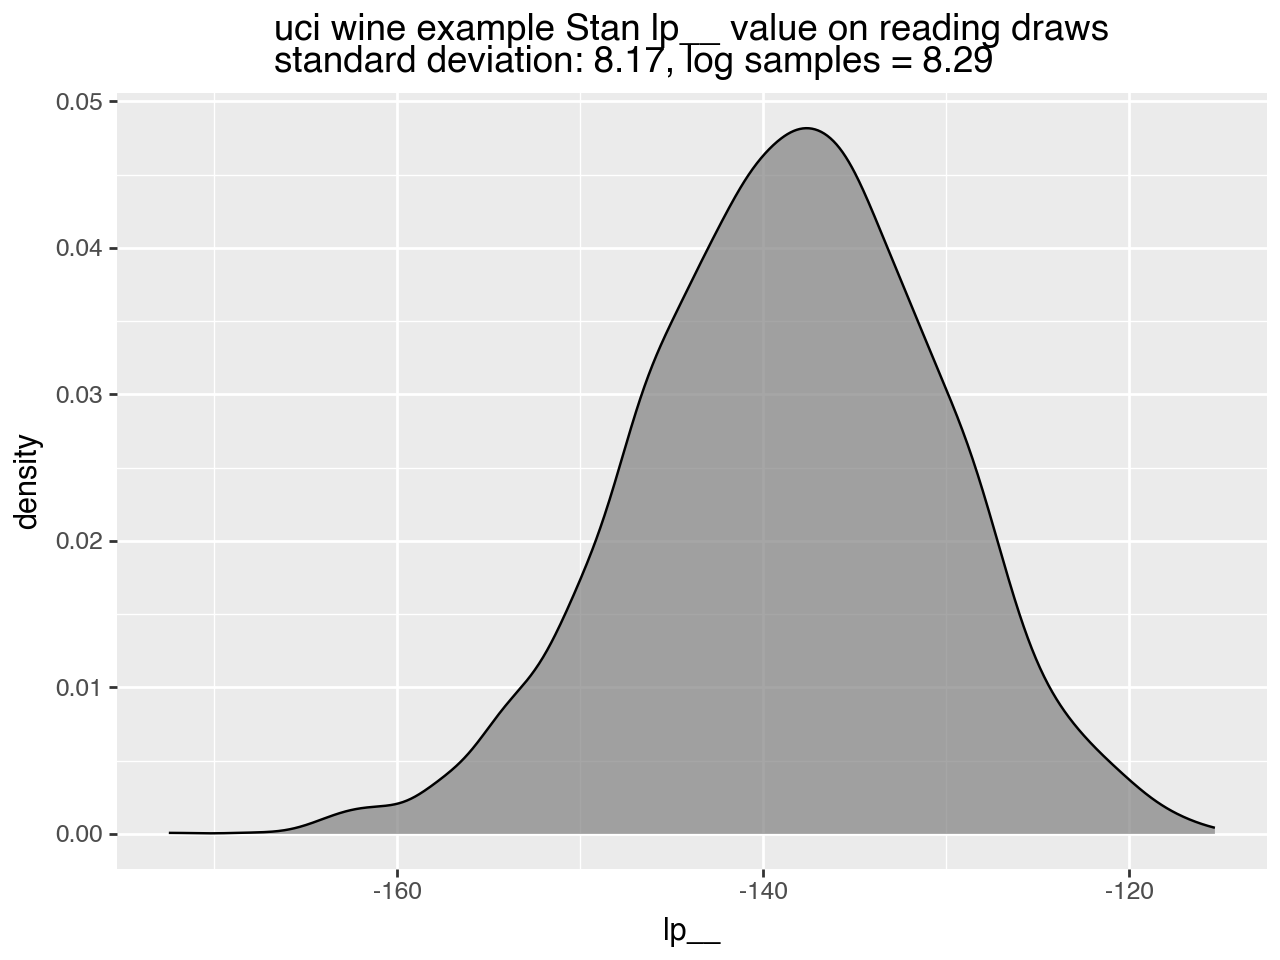

In [22]:
# get implied sample weights from chain
wt_frame = fit_reading.draws_pd(vars=["lp__"])

if do_display:
    stddev = np.sqrt(np.var(wt_frame["lp__"]))
    log_samples = np.log(wt_frame.shape[0])
    (
        ggplot(
            data=wt_frame,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on reading draws\nstandard deviation: {stddev:.2f}, log samples = {log_samples:.2f}"
        )
    ).show()

In [23]:
beta_draws = fit_reading.draws_pd(vars=["beta"])
beta_draws_display = beta_draws.copy()
beta_draws_display.columns = list(features_frame.columns) 

beta_draws_display

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,1.464530,-5.09230,6.330190,-1.130550,-14.466500,0.145566,-0.359092,-8.718790,16.105000,-17.170800,...,-6.80739,0.835535,4.748510,0.101939,-0.013887,1.118130,6.33077,-5.26754,3.052930,9.414590
1,-0.316363,1.41527,9.670890,0.150100,-2.623830,0.390340,-0.273281,-23.331100,15.615600,-11.024600,...,-8.11344,0.568584,5.200660,-0.109156,-0.004674,-8.908410,-2.58826,2.06123,5.430250,8.289620
2,0.889834,-7.36005,-4.740100,0.286264,-1.875670,1.108370,-0.524885,25.451500,-11.970800,0.739414,...,7.04796,0.701765,-0.491377,-0.060981,-0.026094,5.784150,-4.59467,4.99082,1.707020,-6.473840
3,1.749340,-7.80421,-4.252940,-0.199425,3.820190,1.465980,-1.072860,14.732500,-6.718240,-11.290600,...,2.23391,0.129804,-0.808052,0.041251,-0.056272,5.672850,5.94869,4.45724,1.594370,8.480150
4,2.111530,-10.81080,-0.567771,0.399240,2.341870,1.638000,-1.071560,14.727900,-5.524100,-11.048800,...,-0.53369,0.195028,-1.544450,-0.000486,-0.052857,3.374230,5.75137,0.02888,1.919010,-0.362635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.943502,-11.57820,-9.913630,-0.391356,-0.645232,0.372713,-0.247708,-0.295039,5.716300,-1.084880,...,5.75036,1.224050,-15.922200,-0.382967,0.044064,1.831000,-2.84684,16.47870,2.834100,8.602690
3996,-2.237620,-7.77092,3.293170,5.544500,2.749510,0.508675,-0.562954,-1.746900,13.096800,-2.415780,...,3.26823,0.619960,21.512300,-0.020966,-0.030017,1.197310,-0.97213,-1.48589,3.190510,-2.326910
3997,0.092937,4.07390,-2.739400,-0.795738,-3.198400,0.827473,-0.663123,-4.302040,-0.422911,-8.608720,...,-8.12708,1.041970,-6.453810,-0.024488,-0.056220,-4.869470,10.05540,1.35873,1.355570,-13.827200
3998,0.913379,-2.64195,8.567750,-5.201360,0.170590,0.367449,-0.353190,5.328330,-9.720270,-11.254100,...,3.57340,0.918253,0.929658,-0.066929,-0.038450,-0.578982,-1.14552,7.75982,2.794010,5.714260


In [24]:
# this this entirety of what we pull out of Stan- per modeled preference cohort
# from now on we do not use Stan
estimated_beta_reading_Stan = beta_draws_display.loc[
    wt_frame["lp__"] >= np.quantile(wt_frame["lp__"], 0.5), :
].mean()
estimated_beta_reading_Stan

fixed acidity is red             0.260372
volatile acidity is red         -3.177561
citric acid is red               0.748284
residual sugar is red            0.057554
chlorides is red                -1.538651
free sulfur dioxide is red       0.597118
total sulfur dioxide is red     -0.468340
density is red                   0.806114
pH is red                        5.451595
sulphates is red                -3.307342
alcohol is red                   1.280139
fixed acidity is white          -1.774007
volatile acidity is white       -8.386921
citric acid is white            -0.026562
residual sugar is white          0.805214
chlorides is white               0.418662
free sulfur dioxide is white    -0.079599
total sulfur dioxide is white   -0.017096
density is white                -1.082826
pH is white                      1.302114
sulphates is white               5.940469
alcohol is white                 3.262038
is_red                           1.214785
dtype: float64

In [25]:
estimated_beta_reading_Stan = list(estimated_beta_reading_Stan) + [0] * n_alternatives  # TODO: clean

picks


/opt/anaconda3/envs/prob_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log


,row,position,pick probability estimate,was pick
0,0,0,0.3734,False
1,0,1,0.1563,False
2,0,2,0.1947,True
3,0,3,0.0871,False
4,0,4,0.1885,False
5,1,0,0.0922,False
6,1,1,0.3392,True
7,1,2,0.2901,False
8,1,3,0.1704,False
9,1,4,0.1081,False


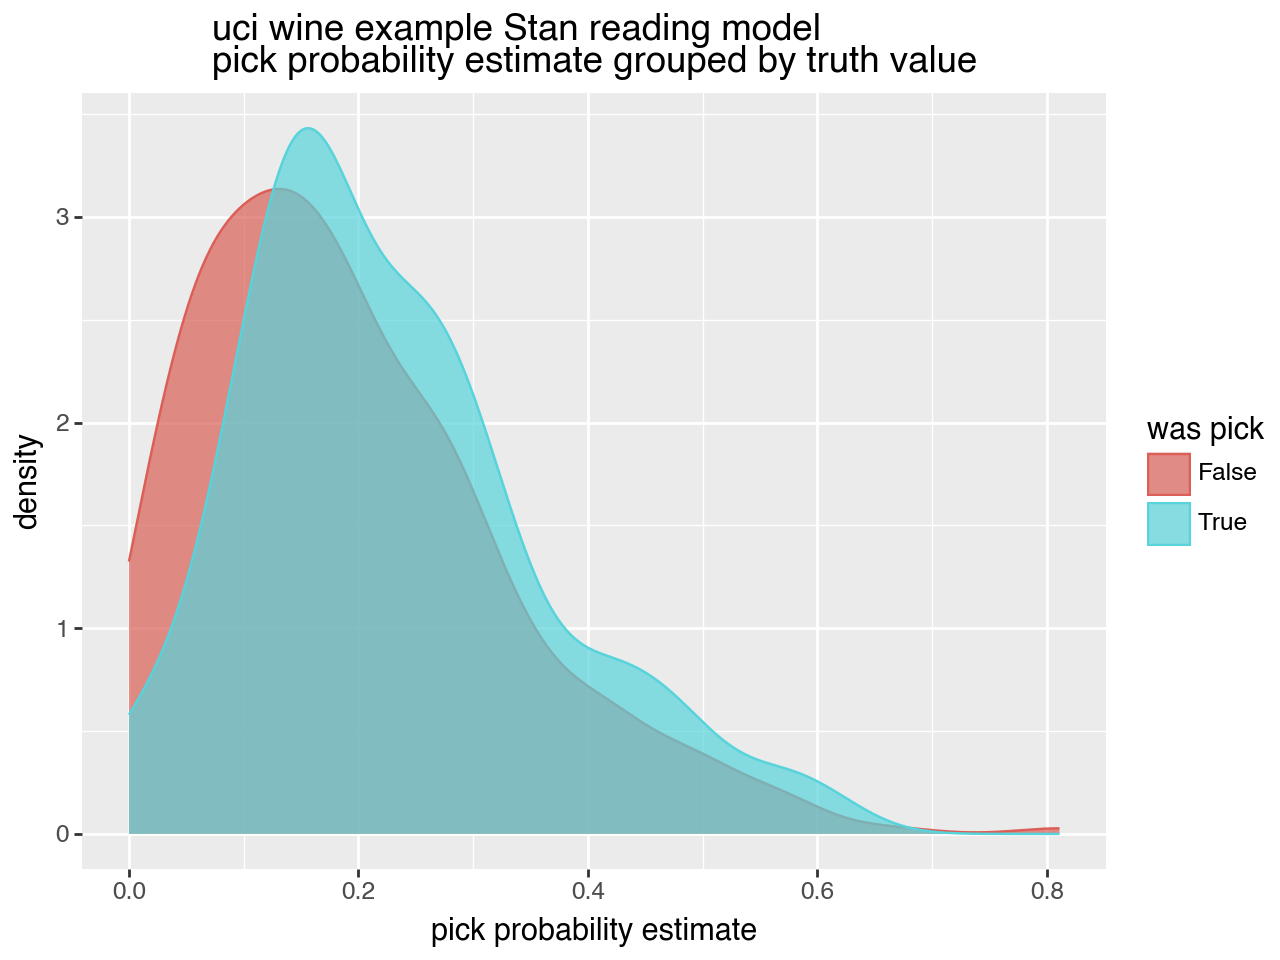

<Figure size 640x480 with 0 Axes>

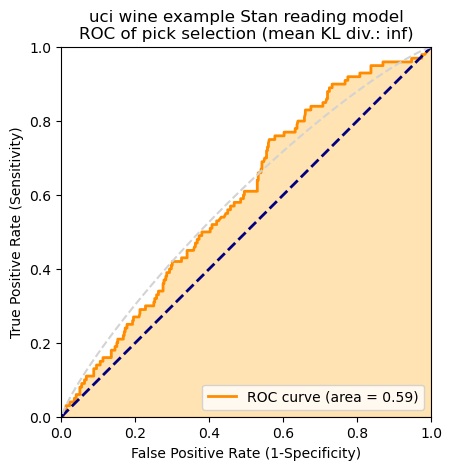

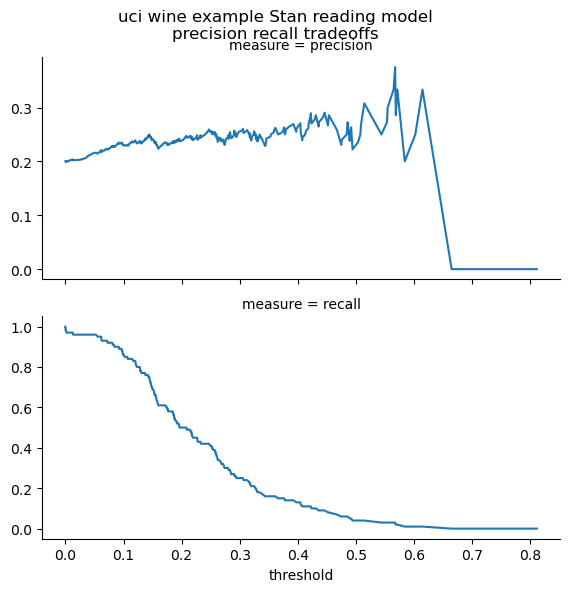

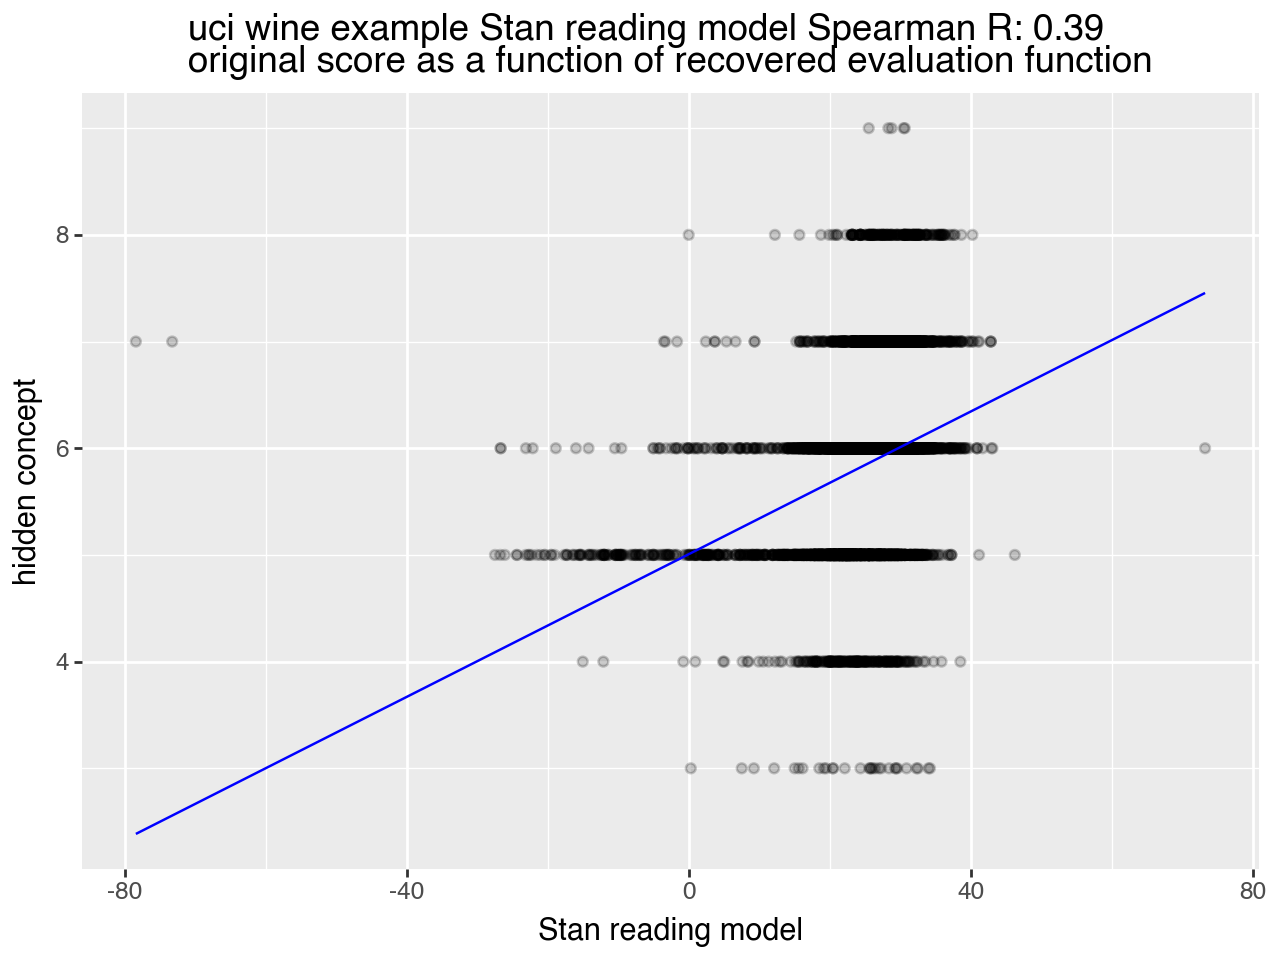

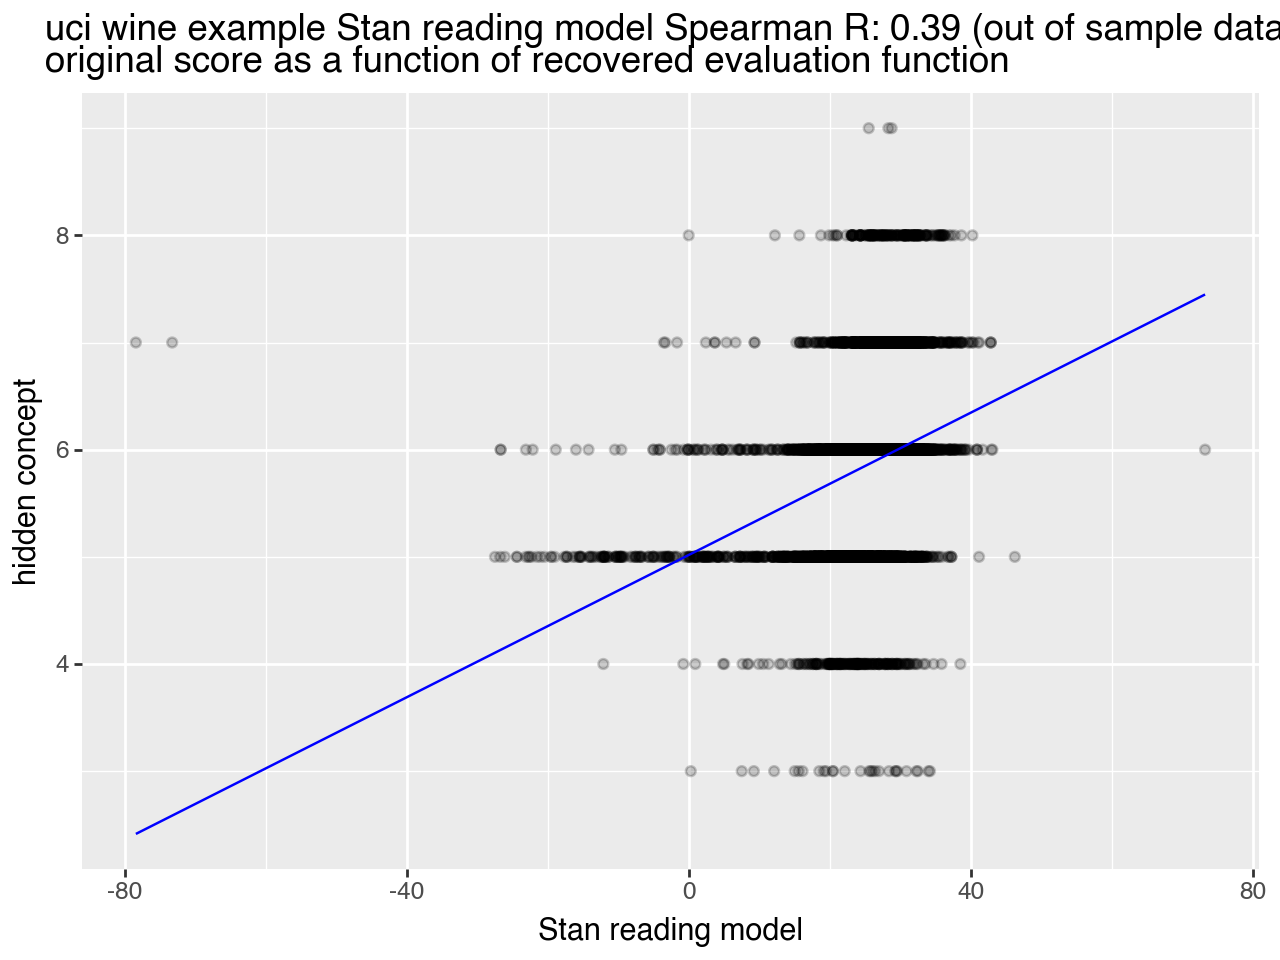

In [26]:
stat_pull_reading_Stan = plot_rank_performance(
    model=estimated_beta_reading_Stan,  # estimated coefficients
    model_type='coef',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name="Stan reading model",  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull_reading_Stan)

Try a Stan model with position choice modeled as utility.

In [27]:
observations_sorted_train = sort_observations_frame(observations_train)

In [28]:
stan_model_panel_src = define_Stan_panel_src(n_alternatives=n_alternatives)
if do_display:
    print(stan_model_panel_src)
data_str = format_Stan_data(
    observations_sorted=observations_sorted_train,
    features_frame=features_frame,
)
fit_utility_Stan = run_stan_model(
    stan_model_src=stan_model_panel_src,
    data_str=data_str,
)


data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
  vector[m_examples] error_picked;          // reified noise term on picks (the secret sauce!)
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] v_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // mod

In [29]:
beta_draws_utility = fit_utility_Stan.draws_pd(vars=["beta"])
beta_draws_utility_display = beta_draws_utility.copy()
beta_draws_utility_display.columns = list(features_frame.columns) + [
    f'position_{sel_j}' for sel_j in range(n_alternatives)
]

beta_draws_utility_display

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,density is white,pH is white,sulphates is white,alcohol is white,is_red,position_0,position_1,position_2,position_3,position_4
0,0.418873,-4.918540,7.09479,-0.786603,-2.464340,0.253120,-0.075725,-0.756662,-0.945380,-12.40980,...,13.71020,-8.713350,25.04800,3.606240,-2.03250,12.67940,4.328170,4.955960,-0.105867,-5.91706
1,1.196800,-0.143435,6.25932,-3.251700,-9.553670,-0.091849,-0.077677,1.523730,3.150500,4.68919,...,-12.10440,-3.544110,1.71199,3.845360,-8.32711,11.13340,7.154630,5.900600,0.619902,-4.42940
2,-2.063130,-6.964140,1.58835,-0.121670,-4.767210,0.082947,-0.059789,-1.525160,0.387566,-1.85023,...,15.82720,-0.212638,20.01410,0.022176,-5.00302,6.33739,-0.794831,-2.868120,-7.465430,-8.12172
3,2.019460,10.690000,9.31121,-2.054550,-13.849300,0.183612,-0.219613,4.826610,8.836590,-1.95982,...,-15.36540,9.828330,-7.40718,1.810590,3.56392,4.49914,-2.367030,-1.459630,-6.914640,-13.70170
4,0.240075,11.900600,-2.98905,3.116840,2.564630,0.462067,-0.220083,9.521210,-7.203430,-8.52788,...,-1.91697,3.636500,12.25170,1.259490,-10.05160,2.45335,-4.883700,-4.978740,-7.858610,-12.20240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-0.134622,-6.968430,-5.14873,-2.958440,-9.394190,-0.096120,-0.018496,-11.024600,-4.126430,-18.52990,...,-5.22625,-2.807930,11.84210,2.397940,11.96570,3.50091,-0.438469,-7.322630,-9.372690,-11.29700
3996,0.892142,-8.735920,3.80713,-1.151370,0.193283,0.357403,-0.152789,14.427500,-9.641750,-23.26170,...,-2.34140,-2.612700,3.84583,3.094730,-7.69168,3.79228,-3.227860,-5.798650,-8.251080,-17.81740
3997,0.782391,-4.072210,7.56647,-2.877740,0.422848,-0.380789,0.064778,-3.359740,2.608440,15.93650,...,-14.10440,14.820500,5.75326,1.293410,17.05470,-1.96056,-6.515180,-7.462320,-11.290400,-13.64220
3998,1.423660,-5.551640,-3.95894,0.136795,-12.156900,-0.015113,-0.155472,3.968550,3.453680,-12.95450,...,-12.56370,9.397260,4.40303,0.753543,21.50630,3.88243,-3.579040,-4.172290,-4.010460,-8.00525


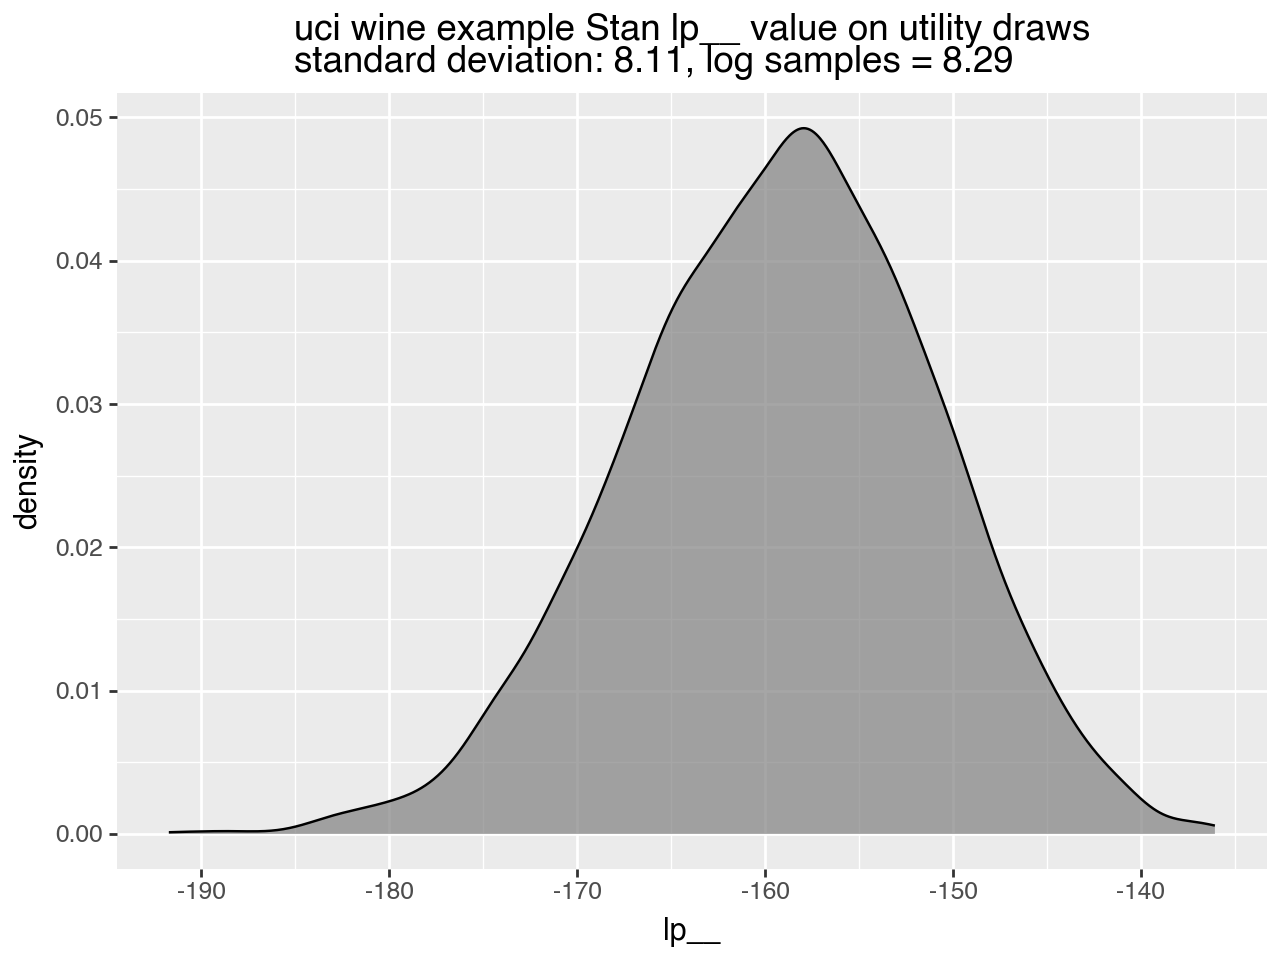

In [30]:
# get implied sample weights from chain
wt_frame_utility = fit_utility_Stan.draws_pd(vars=["lp__"])

if do_display:
    stddev = np.sqrt(np.var(wt_frame_utility["lp__"]))
    log_samples = np.log(wt_frame_utility.shape[0])
    (
        ggplot(
            data=wt_frame_utility,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on utility draws\nstandard deviation: {stddev:.2f}, log samples = {log_samples:.2f}"
        )
    ).show()

In [31]:
estimated_beta_utility_Stan = beta_draws_utility_display.loc[
    wt_frame["lp__"] >= np.quantile(wt_frame_utility["lp__"], 0.5), :
].mean()
estimated_beta_utility_Stan

fixed acidity is red             0.180367
volatile acidity is red         -4.013065
citric acid is red               3.400454
residual sugar is red           -0.928436
chlorides is red                -2.085892
free sulfur dioxide is red       0.265858
total sulfur dioxide is red     -0.175324
density is red                   1.019362
pH is red                        4.578446
sulphates is red                -5.298557
alcohol is red                   0.798435
fixed acidity is white          -1.360023
volatile acidity is white       -9.996753
citric acid is white            -2.714386
residual sugar is white          0.559503
chlorides is white               0.547589
free sulfur dioxide is white    -0.046037
total sulfur dioxide is white   -0.001018
density is white                -1.216095
pH is white                      0.622184
sulphates is white               5.588558
alcohol is white                 2.424908
is_red                           1.443602
position_0                       8

picks


,row,position,pick probability estimate,was pick
0,0,0,0.6115,False
1,0,1,0.1775,False
2,0,2,0.1454,True
3,0,3,0.0339,False
4,0,4,0.0317,False
5,1,0,0.3298,False
6,1,1,0.3653,True
7,1,2,0.2118,False
8,1,3,0.0619,False
9,1,4,0.0312,False


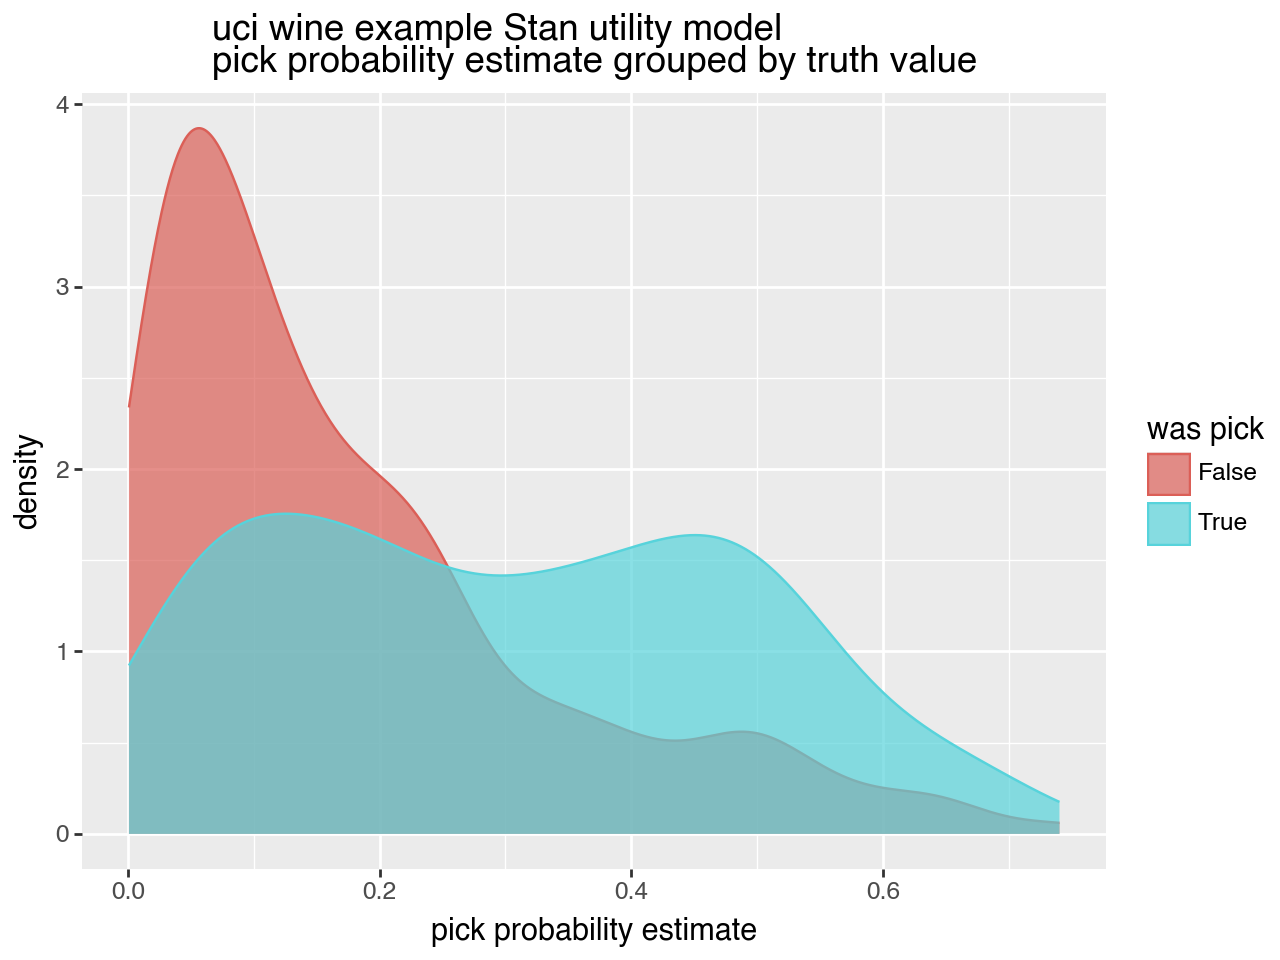

<Figure size 640x480 with 0 Axes>

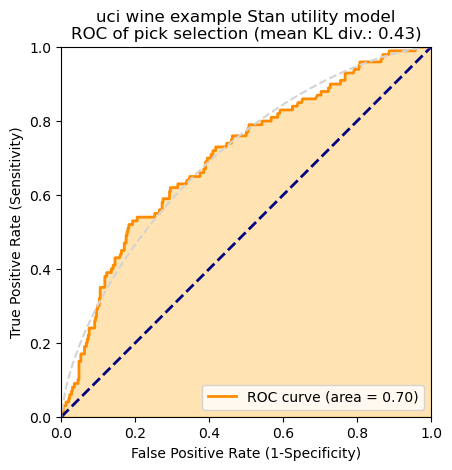

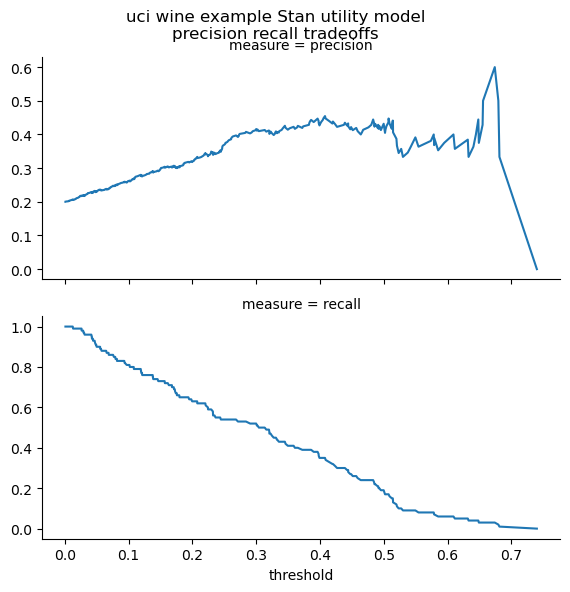

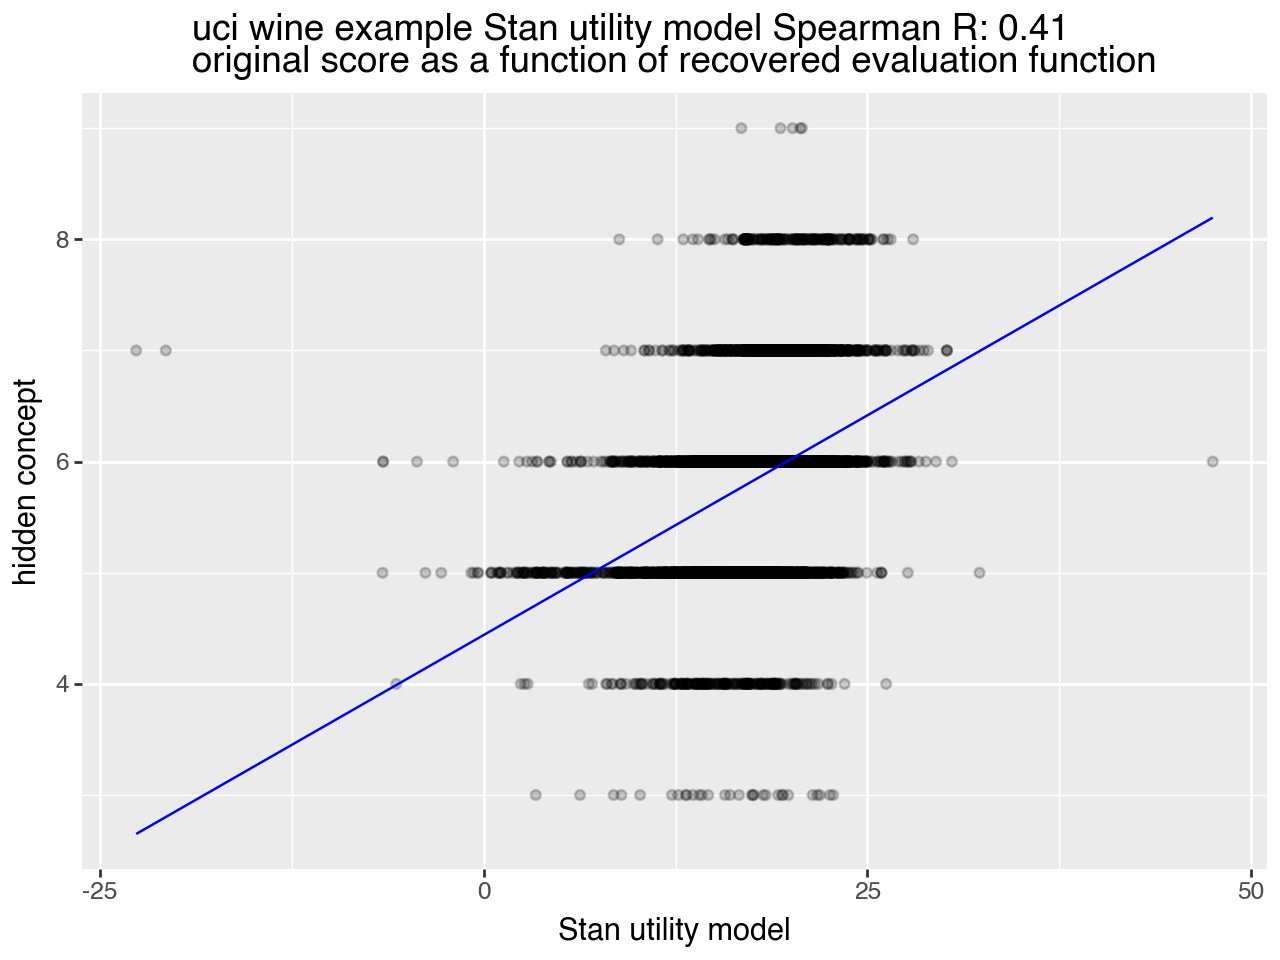

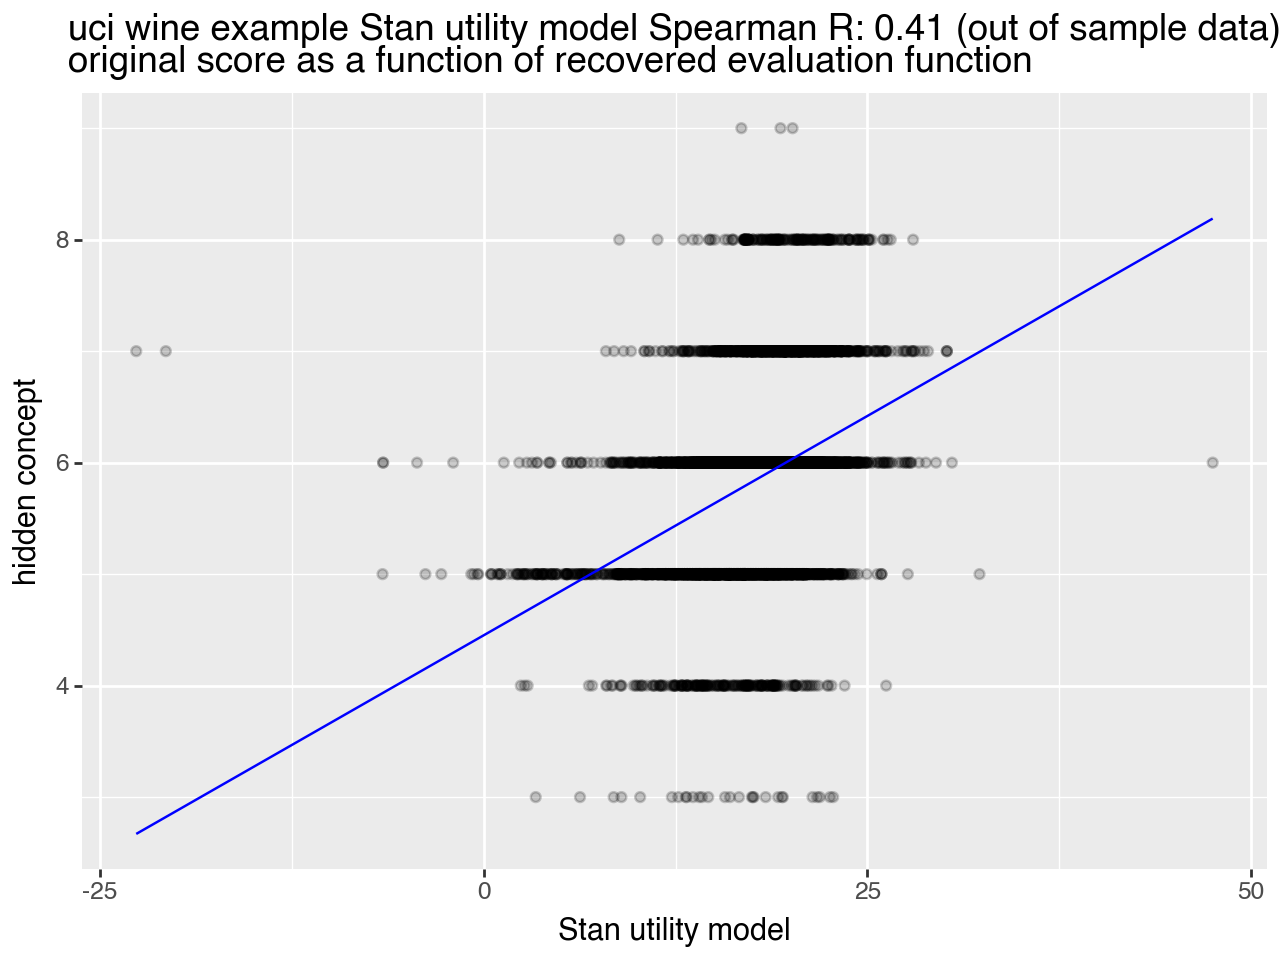

In [32]:
stat_pull_Stan = plot_rank_performance(
    model=estimated_beta_utility_Stan,  # estimated coefficients
    model_type='coef',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name="Stan utility model",  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull_Stan)

Try to approximate the Stan model with a classification model with similar error structure.
Consider each pair of panel entries with a different outcome as an observation and try to
build a model that reproduces the observed outcomes.
The extra trick is: repeat the whole data frame negated with the outcomes reverse (so 
we don't define a problem with all positive or all negative outcomes).


In [33]:

feature_names = list(features_frame.columns) + [
    f"position_{sel_i}" for sel_i in range(n_alternatives)
]
enc_frame = []
for row_i in range(observations_train.shape[0]):
    feature_row = observations_train.loc[row_i, :]
    sel_pick = np.argmax(
        feature_row[[f"pick_value_{sel_i}" for sel_i in range(n_alternatives)]]
    )
    for sel_i in range(n_alternatives):
        if sel_i != sel_pick:
            posn_vec = [0] * n_alternatives
            posn_vec[sel_pick] = 1.0
            posn_vec[sel_i] = -1.0
            encoded_row = list(
                    features_frame.loc[feature_row[f"item_id_{sel_pick}"], :]
                    - features_frame.loc[feature_row[f"item_id_{sel_i}"], :]
                ) + posn_vec  
            di = pd.DataFrame({k: [v] for k, v in zip(feature_names, encoded_row)})
            enc_frame.append(di)
enc_frame = pd.concat(enc_frame, ignore_index=True)

In [34]:
classification_model = LogisticRegression(max_iter=10000, solver="newton-cholesky")
classification_model_name = 'logistic'

# classification_model = XgboostClassifier(rng=rng)
# classification_model_name = 'xgboost'

# classification_model = RandomForestClassifier()
# classification_model_name = 'Random Forest'

In [35]:

classification_model.fit(
    X=pd.concat([enc_frame, -enc_frame], ignore_index=True),
    y=[True] * enc_frame.shape[0] + [False] * enc_frame.shape[0],
)

LogisticRegression(max_iter=10000, solver='newton-cholesky')

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2451,False
1,0,1,0.2146,False
2,0,2,0.2043,True
3,0,3,0.1709,False
4,0,4,0.1651,False
5,1,0,0.2227,False
6,1,1,0.2332,True
7,1,2,0.2033,False
8,1,3,0.1762,False
9,1,4,0.1646,False


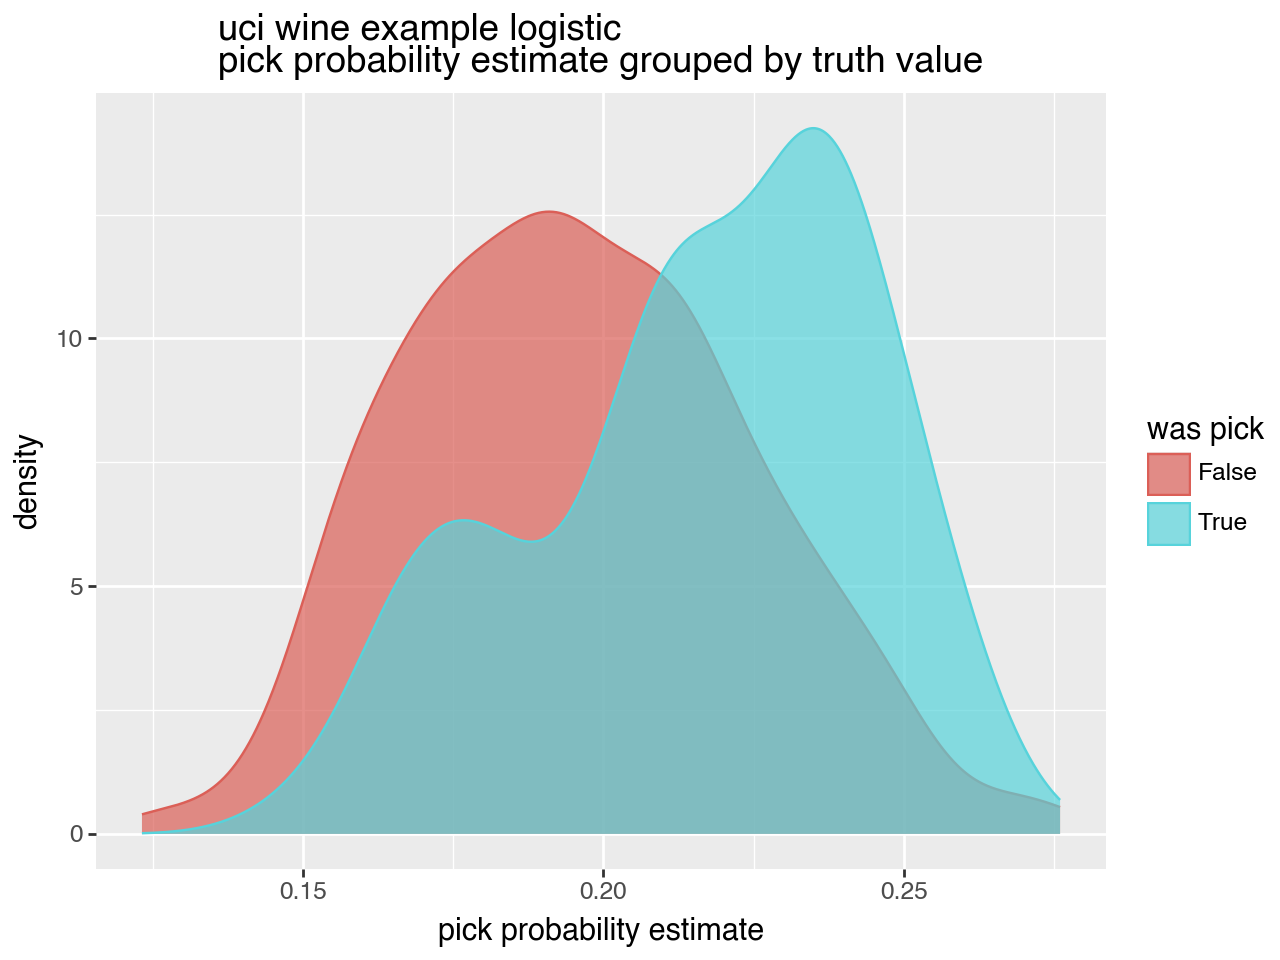

<Figure size 640x480 with 0 Axes>

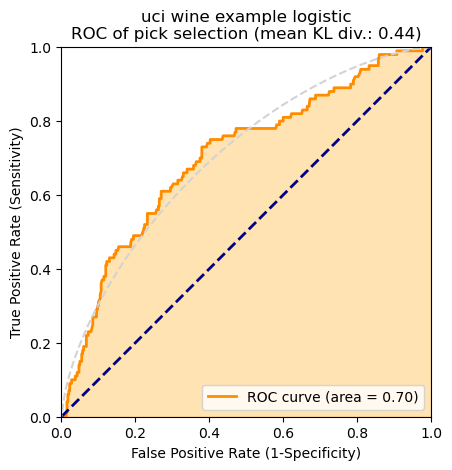

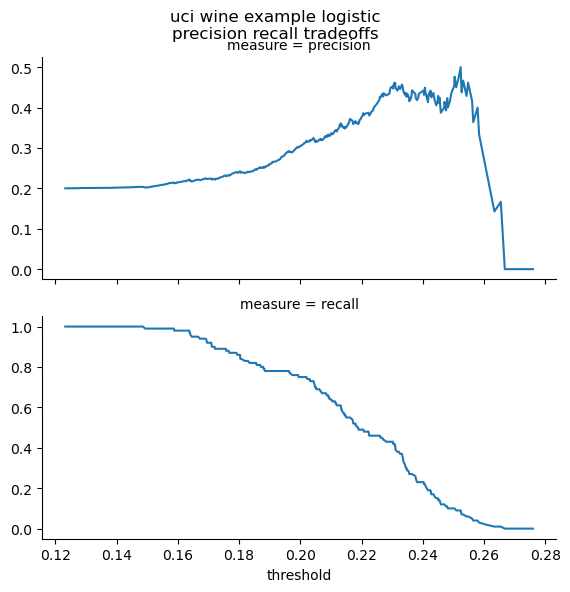

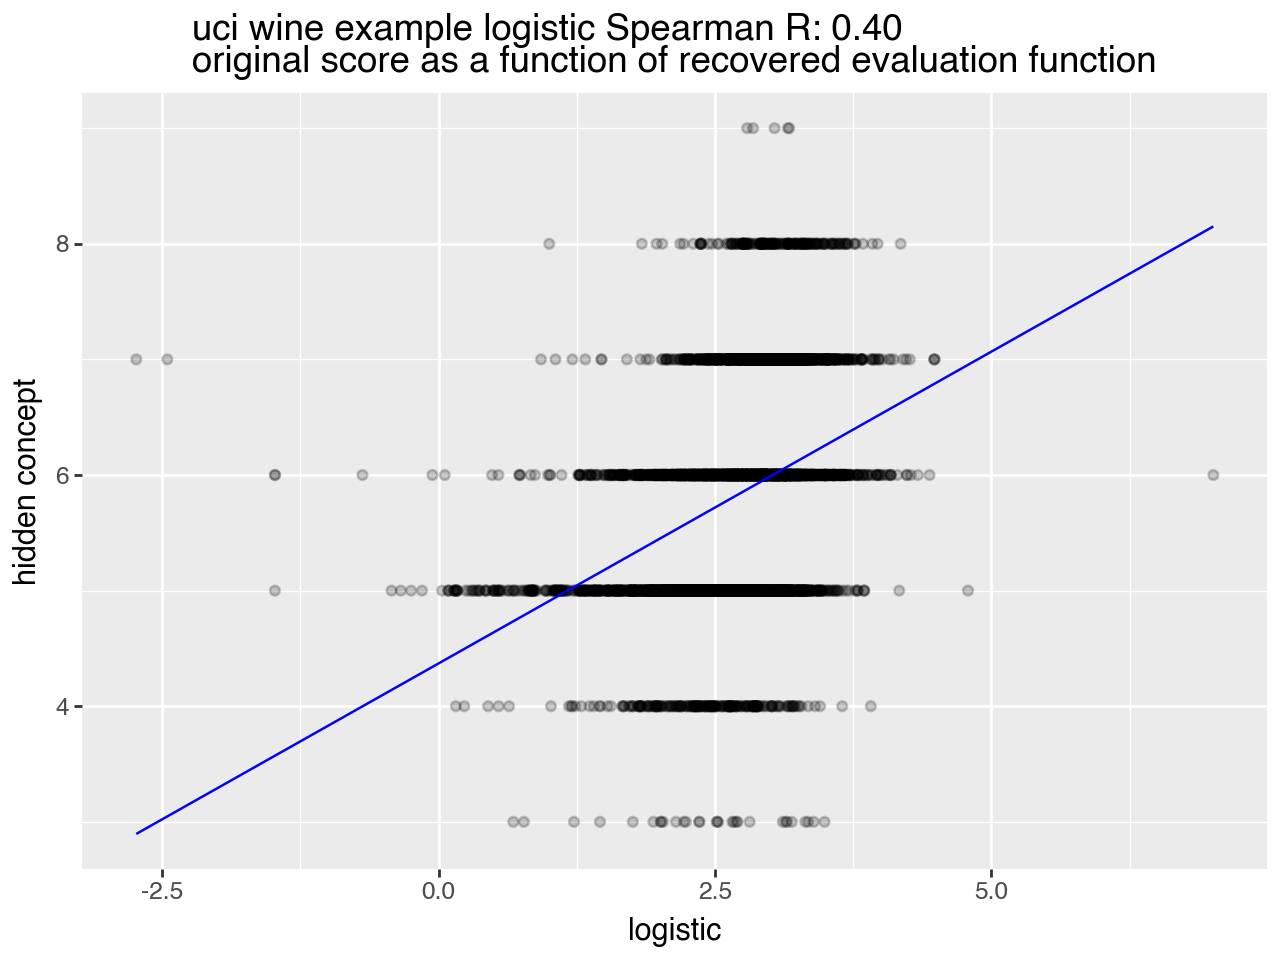

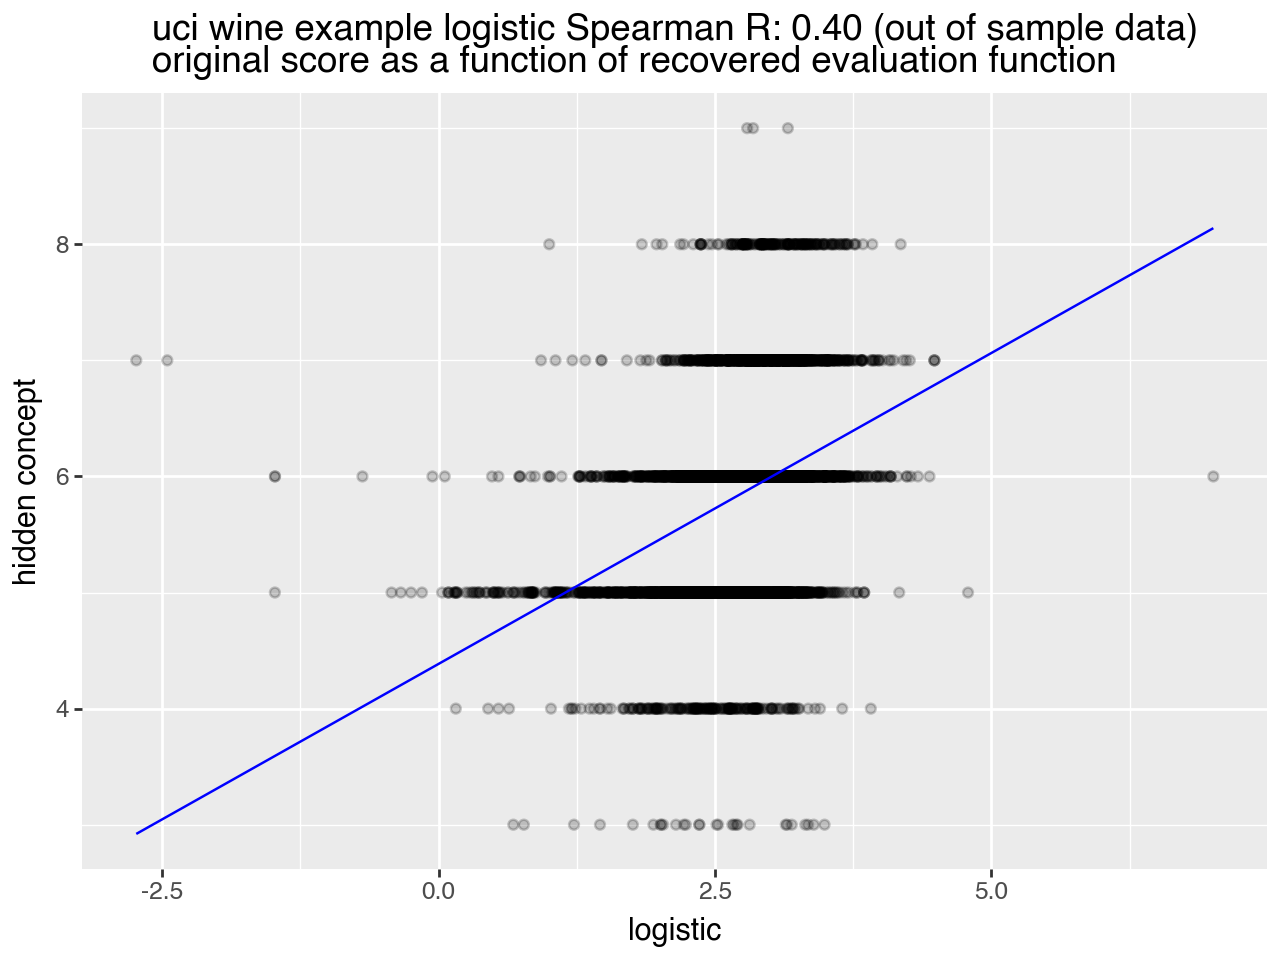

In [36]:
stat_pull_classifier = plot_rank_performance(
    model=classification_model,
    model_type='classifier',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name=classification_model_name,  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull_classifier)

We can compare this to just looking at the scores (not implementable in real world problems).

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2107,False
1,0,1,0.1969,False
2,0,2,0.2126,True
3,0,3,0.1951,False
4,0,4,0.1847,False
5,1,0,0.1908,False
6,1,1,0.2103,True
7,1,2,0.2092,False
8,1,3,0.1998,False
9,1,4,0.1899,False


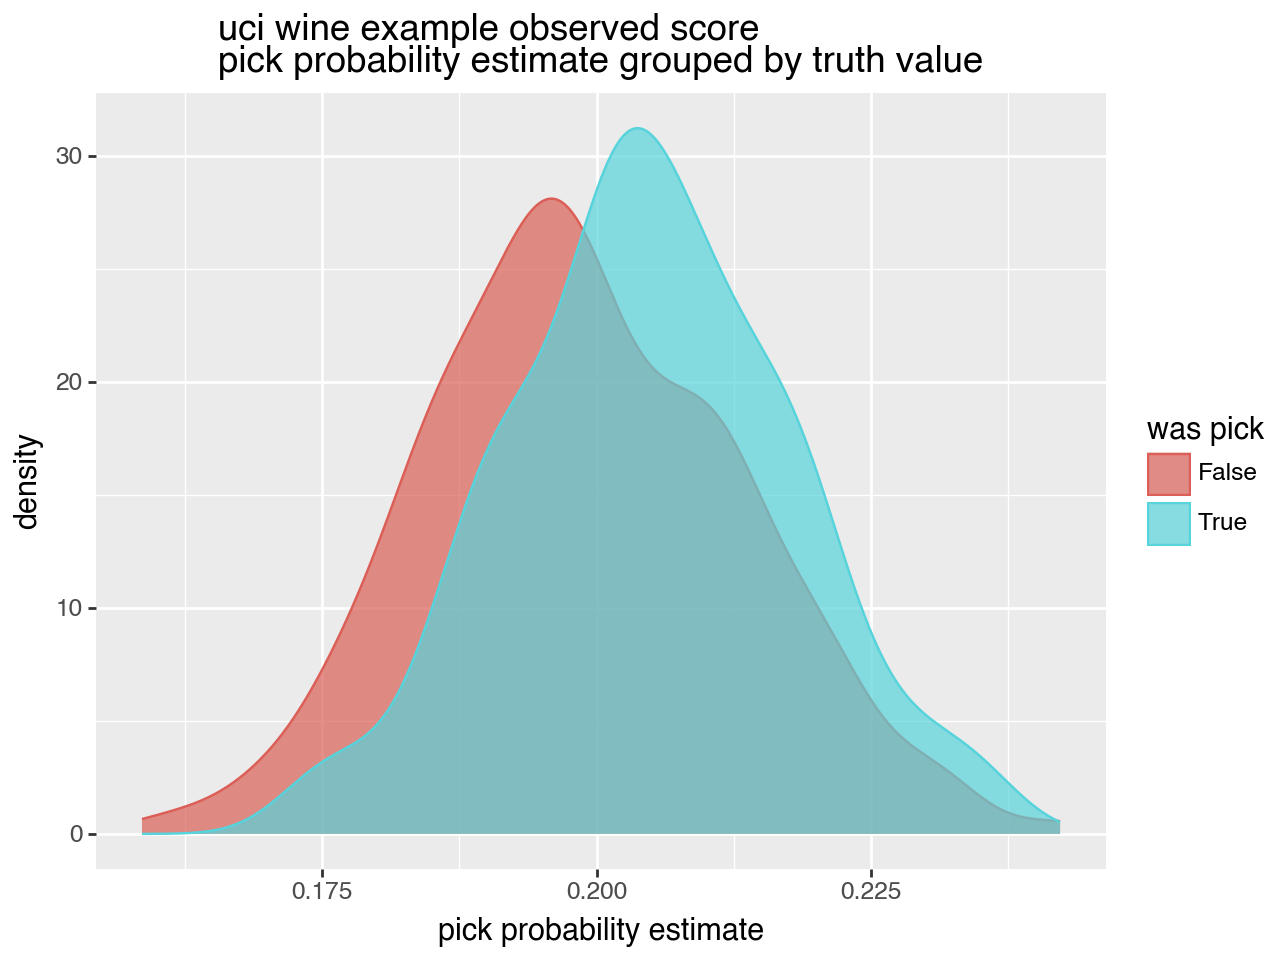

<Figure size 640x480 with 0 Axes>

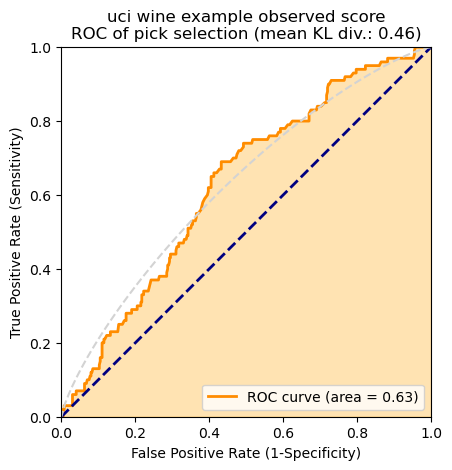

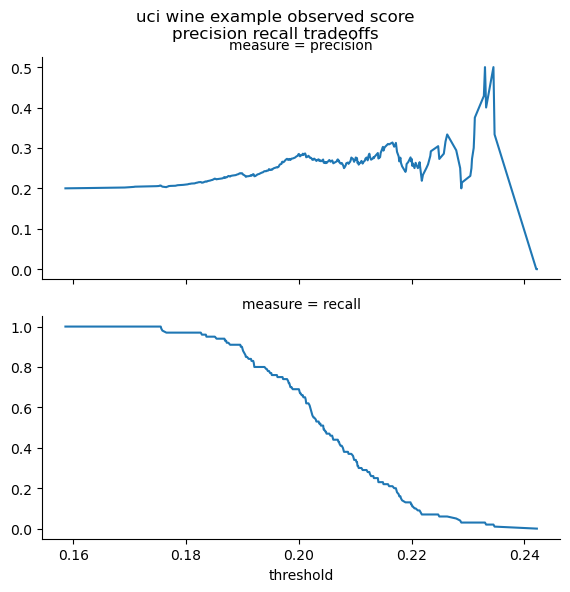

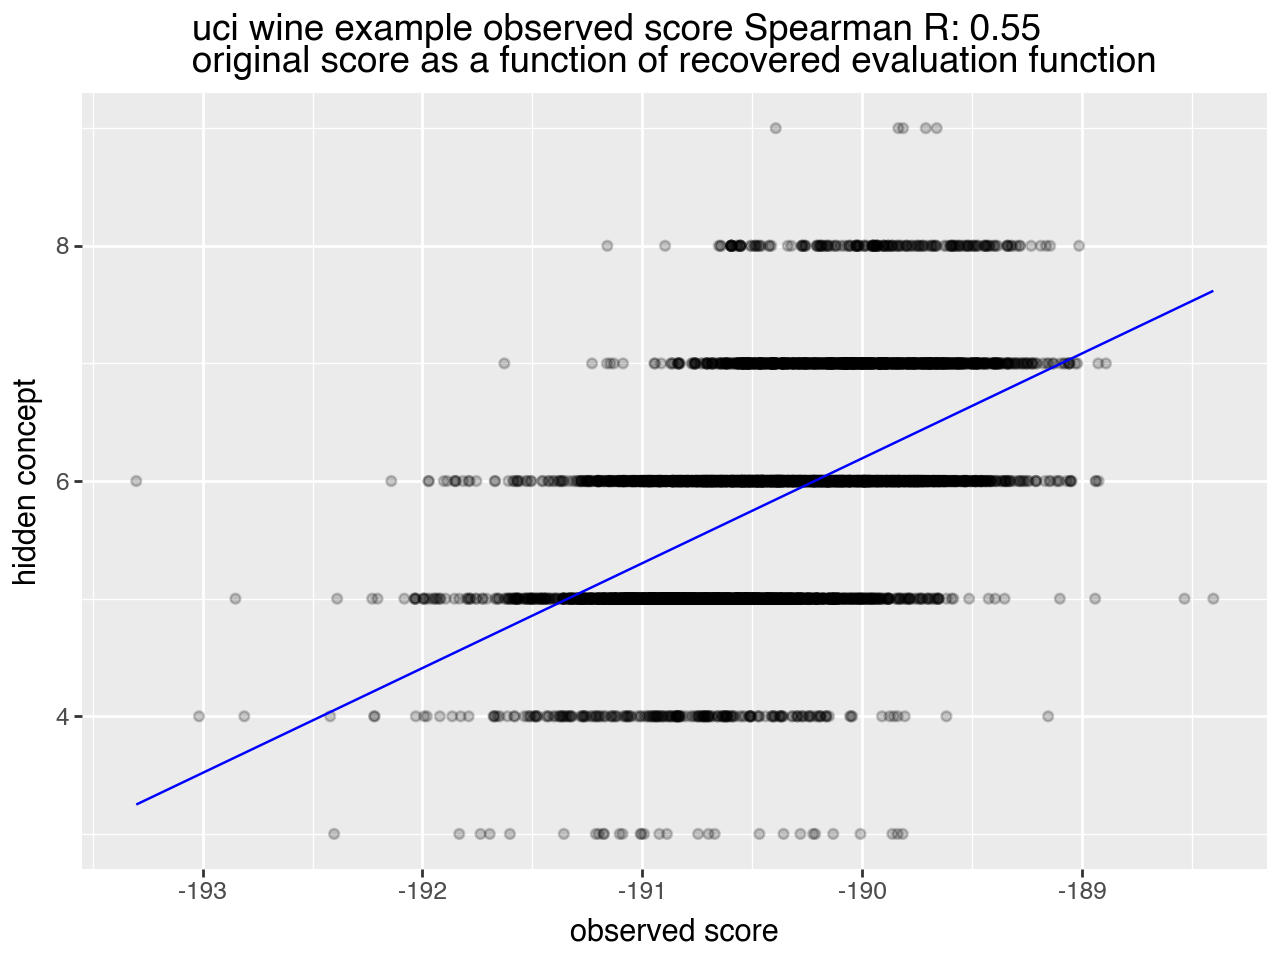

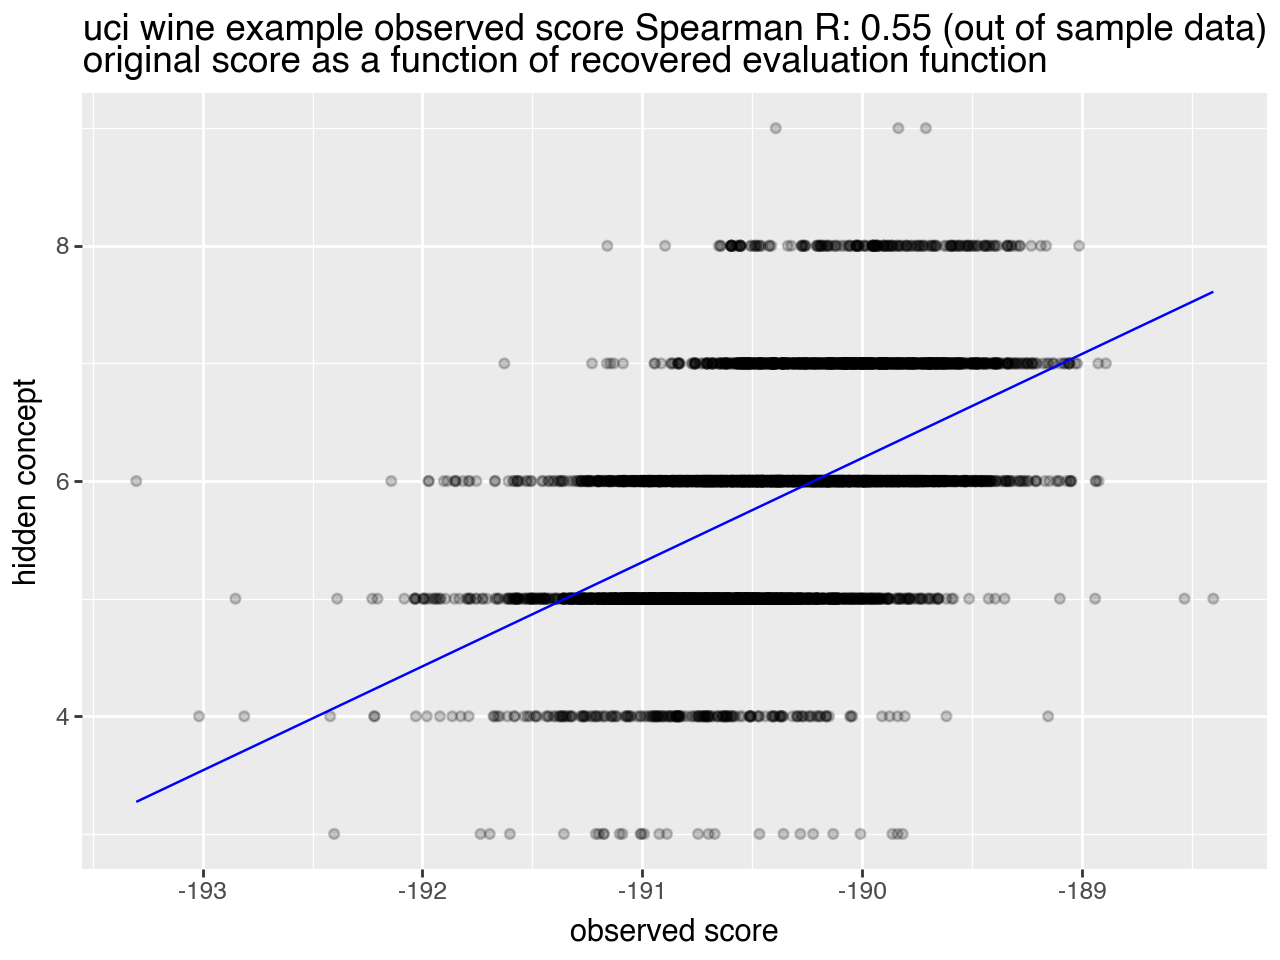

In [37]:
# plug in the perfect model that saw the scores
if know_score and (perfect_coef is not None):
    perfect_pull = plot_rank_performance(
        model=perfect_coef,  # estimated coefficients
        model_type='coef',  # TODO pass regression model directly
        example_name=example_name,  # name of data set
        n_alternatives=n_alternatives,  # size of panels
        features_frame=features_frame,  # features by row id
        observations_train=observations_train,  # training observations layout frame
        observations_test=observations_test,  # evaluation observations layout frame
        estimate_name="observed score",  # display name of estimate
        score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
        rng=rng,  # pseudo random source
        show_plots=do_display,
    )
    collected_stats.append(perfect_pull)

In [38]:
collected_stats = pd.concat(collected_stats, ignore_index=True)
# collected_stats['perfect_model_SpearmanR'] = perfect_model_SpearmanR

In [39]:
if (result_fname is not None) and (len(result_fname) > 0):
    collected_stats.to_csv(result_fname, index=False)

In [40]:
if do_display:
    display(collected_stats)

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_auc,mean pick KL divergence,training panels,test panels,data_size,test_size
0,uci wine example,Stan reading model,0.388377,0.387250,0.590775,inf,100,100,6497,6013
1,uci wine example,Stan utility model,0.406167,0.405108,0.703137,0.430724,100,100,6497,6013
2,uci wine example,logistic,0.401345,0.399807,0.702450,0.444034,100,100,6497,6013
3,uci wine example,observed score,0.551482,0.549029,0.627475,0.458029,100,100,6497,6013
